In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from functools import reduce

from torchviz import make_dot

In [29]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5*5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation
        # input 1 * 1 * 32 * 32
        # conv1 (32 - 4) / 1 = 28
        # maxpool2d 14 * 14
        # conv2 10 * 10
        # maxpool2d 5 * 5
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        # Max pooling over a (2, 2) window, stride is 2
        # how is the stride determined?
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # if the size is a squre you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        # all dimensions except the batch dimension
        return reduce(lambda x,y: x*y, x.size()[1:], 1)
    
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [30]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 5, 5])


In [31]:
input = torch.randn(1, 1, 32, 32)
# If you have a single sample
# just use input.unsqueeze(0) to add a fake batch dimension.
out = net(input)
print(out)

tensor(1.00000e-02 *
       [[ 8.3017,  0.5837, -2.9926,  2.2310,  1.6603,  2.9562,  4.3609,
          4.0735,  4.4459,  6.1330]])


In [28]:
# gradient is accumulated every backprop
# so you should set all model parameters to zero
net.zero_grad()
out.backward(torch.randn(1, 10))

In [32]:
target = torch.arange(1, 11) # 1D tensor [1, ... ,10]
print(target.size())

torch.Size([10])


In [34]:
target = target.view(1, -1) # rearrange it as 2D, same with the output
print(target.size())
criterion = nn.MSELoss()

torch.Size([1, 10])


In [49]:
loss = criterion(out, target)
print(loss)
print(loss.grad_fn)
print(loss.grad_fn.next_functions[0][0])
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])

tensor(38.1021)


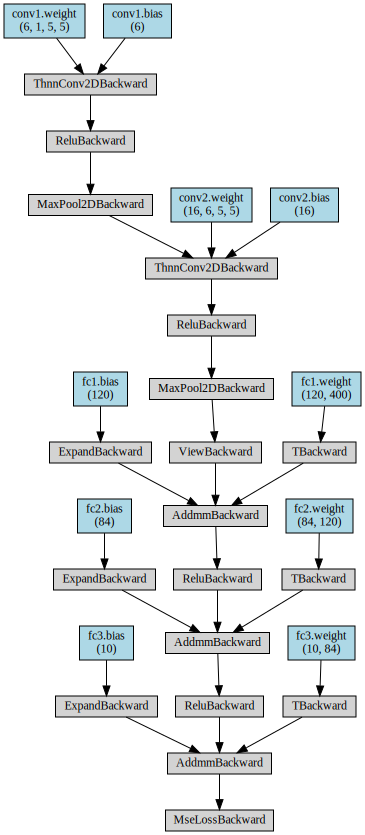

In [44]:
make_dot(loss, params=dict(net.named_parameters()))

## Backprop

In [50]:
net.zero_grad()
print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
None
conv1.bias.grad after backward
tensor([-0.1099, -0.0092, -0.0785, -0.0144,  0.0894,  0.0212])


In [51]:
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

In [56]:
# Another way to update
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=0.01)

optimizer.zero_grad() # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step() # Does the update